In [1]:
import pandas as pd
from database.news import News
from textblob import TextBlob
from modeler.modeler import Modeler as m
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle

In [2]:
news = News()

In [4]:
t_df = pd.read_csv("True.csv")
t_df["y"] = 1
f_df = pd.read_csv("Fake.csv")
f_df["y"] = 0
ds = pd.concat([t_df,f_df])

In [6]:
ds["polarity"] = [TextBlob(x).sentiment.polarity for x in ds["text"]]
ds["subjectivity"] = [TextBlob(x).sentiment.subjectivity for x in ds["text"]]
ds["tpolarity"] = [TextBlob(x).sentiment.polarity for x in ds["title"]]
ds["tsubjectivity"] = [TextBlob(x).sentiment.subjectivity for x in ds["title"]]

In [7]:
ds

,title,text,subject,date,y,polarity,subjectivity,tpolarity,tsubjectivity
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,0.037083,0.410250,0.00,0.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,0.055880,0.298557,-0.10,0.1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,0.115930,0.316798,0.00,0.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,0.035968,0.306569,0.00,0.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,0.030093,0.399891,0.35,0.3
...,...,...,...,...,...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,0.067264,0.497359,0.00,0.0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,0.097059,0.538235,0.00,0.0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,0.072183,0.417284,0.50,0.5
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,0.088294,0.396429,0.00,1.0


In [3]:
news.connect()
ds = news.retrieve("sentiments").drop("_id",axis=1)
news.disconnect()

In [7]:
## shuffling the dataset
data = ds.sample(frac=1)

In [11]:
data_train = data.iloc[:int(data.index.size * 0.7)]
data_test = data.iloc[int(data.index.size * 0.7):]
factors = ["polarity","subjectivity","tpolarity","tsubjectivity"]
refined_data = {"X":data_train[factors],"y":data_train["y"]}

NameError: name 'data' is not defined

In [9]:
xgb_models = m.xgb_classify(refined_data,multioutput=False)

c:\users\eric\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\eric\appdata\local\programs\python\python38\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\eric\appdata\local\programs

In [15]:
xgb_models["model"] = pickle.dumps(xgb_models["model"])

In [4]:
news.connect()
model = news.retrieve("model")
news.disconnect()

In [13]:
factors = ["polarity","subjectivity","tpolarity","tsubjectivity"]
test = dict(ds.iloc[0][factors])

In [17]:
pd.DataFrame([test])

,polarity,subjectivity,tpolarity,tsubjectivity
0,0.037083,0.41025,NaN,NaN


In [18]:
pickle.loads(model["model"].item()).predict(pd.DataFrame([test]))

array([0], dtype=int64)

<ipython-input-19-022cec1ae294>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["predictions"] = predictions


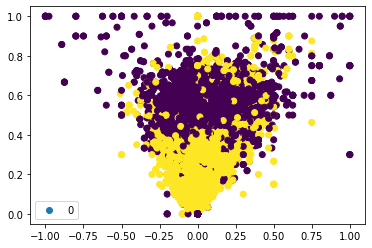

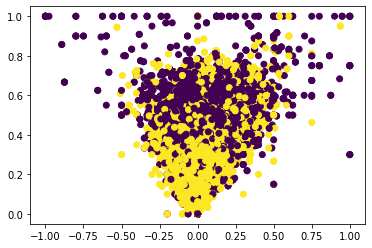

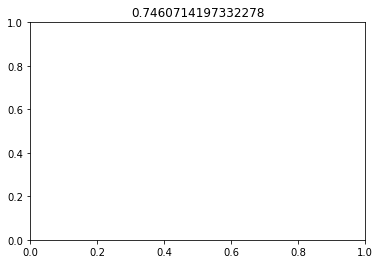

In [19]:
p = []
x = "polarity"
y = "subjectivity"
try:
    model = pickle.loads(xgb_models["model"])
    predictions = model.predict(data_test[factors])
    score = accuracy_score(predictions,data_test["y"])
    data_test["predictions"] = predictions
    plt.scatter(data_test[x],data_test[y],c=data_test["predictions"])
    plt.legend(data_test["predictions"].unique())
    plt.show()
    plt.scatter(data_test[x],data_test[y],c=data_test["y"])
    plt.show()
    plt.title(score)
except Exception as e:
    print(str(e))
    